<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Explainable-AI/Integrating_SHAP_to_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models

In [ ]:
# Define the dataset directory
base_dir = "/content/drive/MyDrive/Preprocessed_Dataset_classification"

In [ ]:
def load_dataset(base_dir):
    """Load the dataset, preprocess images, convert grayscale to RGB, and return data and labels."""
    images, labels = [], []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    # Load the image in grayscale
                    image = tf.io.read_file(file_path)
                    image = tf.image.decode_image(image, channels=1)  # Load as grayscale
                    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
                    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
                    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

                    images.append(image.numpy())
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Could not process {file_path}: {e}")

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    # Display a sample image to confirm RGB conversion
    if len(images) > 0:
        plt.imshow(images[0])  # Matplotlib assumes (H, W, 3) as RGB
        plt.title(f"Sample Image (Class: {class_names[labels[0]]})")
        plt.axis("off")
        plt.show()

    return images, labels, class_names


Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']


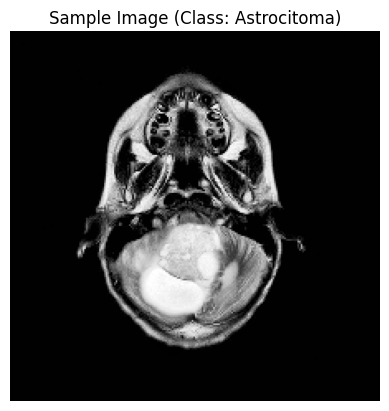

In [ ]:
# Load and split the dataset
images, labels, class_names = load_dataset(base_dir) # Assign class_names
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

1. Hybrid model

In [ ]:
# Load your trained model
model = load_model('/content/drive/MyDrive/dsgp_models/Brain_Tumour_Classification_hybrid_model_Last.keras')

In [ ]:
# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       600
           1       1.00      1.00      1.00       600
           2       0.99      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600
           6       1.00      1.00      1.00       600
           7       1.00      1.00      1.00       600
           8       0.99      0.99      0.99       600
           9       0.99      1.00      1.00       600
          10       1.00      1.00      1.00       600
          11       1.00      0.99      0.99       600
          12       1.00      1.00      1.00       600
          13       0.99      0.94      0.96       600
          14       0.97      0.97      0.97       600
          15       0.96      0.99      0.98       600

    accuracy                           0.99      9600
   

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.49s/it]               


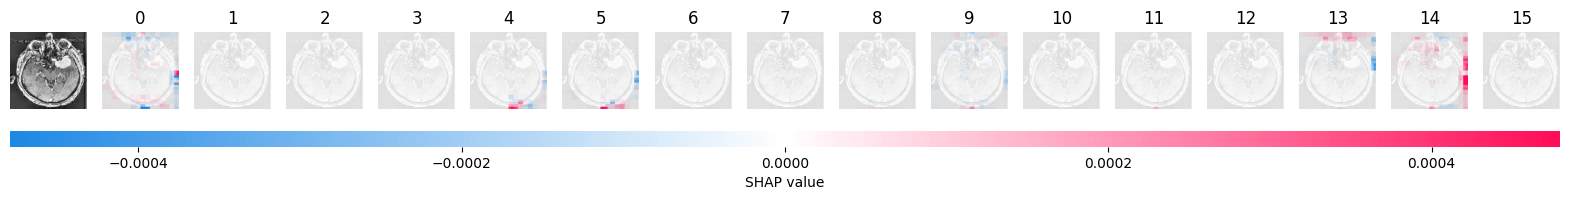

In [ ]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(224,224)", test_images[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(16)))
ind=[200]
shap_values_ = explainer( test_images[ind], max_evals=5000, batch_size=50 )
shap.image_plot(shap_values_,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.27s/it]               


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


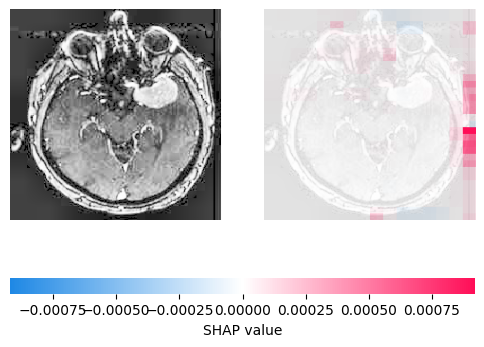

In [ ]:
# Function to get predictions
def f(x):
    return model(x)

# Defining the SHAP masker and explainer
masker_blur = shap.maskers.Image("blur(224,224)", test_images[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(16)))
ind = 200
shap_values_ = explainer(test_images[[ind]], max_evals=5000, batch_size=50)

image_to_predict = test_images[[ind]]
predictions = model.predict(image_to_predict)
predicted_class = np.argmax(predictions, axis=1)[0]

shap_values_predicted_class = shap_values_.values[..., predicted_class]
shap.image_plot([shap_values_predicted_class], test_images[[ind]])

2. ViT model

In [ ]:
# Load your trained model
model = load_model('/content/drive/MyDrive/dsgp_models/ViT_model_RGBFinal.keras')

In [ ]:
# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       600
           1       1.00      0.99      0.99       600
           2       0.98      1.00      0.99       600
           3       1.00      1.00      1.00       600
           4       0.99      1.00      0.99       600
           5       0.98      0.98      0.98       600
           6       1.00      1.00      1.00       600
           7       0.99      1.00      0.99       600
           8       0.94      0.97      0.96       600
           9       0.99      0.99      0.99       600
          10       0.99      0.98      0.99       600
          11       0.99      0.96      0.98       600
          12       0.99      1.00      1.00       600
          13       0.93      0.82      0.87       600
          14       0.84      0.96      0.89       600
          15       0.92      0.93      0.93       600

    accuracy   

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.37s/it]               


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


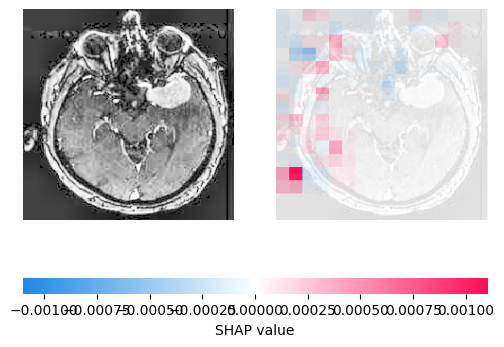

In [ ]:
# Function to get predictions
def f(x):
    return model(x)

# Defining the SHAP masker and explainer
masker_blur = shap.maskers.Image("blur(224,224)", test_images[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(16)))
ind = 200
shap_values_ = explainer(test_images[[ind]], max_evals=5000, batch_size=50)

image_to_predict = test_images[[ind]]
predictions = model.predict(image_to_predict)
predicted_class = np.argmax(predictions, axis=1)[0]

shap_values_predicted_class = shap_values_.values[..., predicted_class]
shap.image_plot([shap_values_predicted_class], test_images[[ind]])

3. CNN model

In [ ]:
# Load your trained model
model = load_model('/content/drive/MyDrive/dsgp_models/cnn_model (1).keras')

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.60s/it]               


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


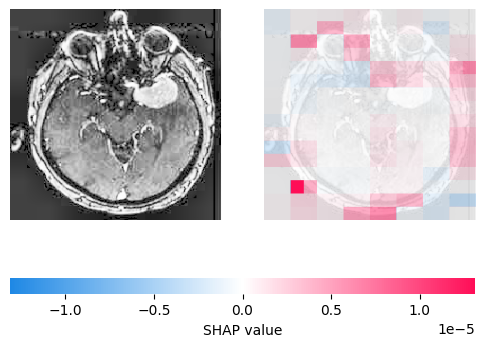

In [ ]:
# Function to get predictions
def f(x):
    return model(x)

# Defining the SHAP masker and explainer
masker_blur = shap.maskers.Image("blur(224,224)", test_images[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(16)))
ind = 200
shap_values_ = explainer(test_images[[ind]], max_evals=5000, batch_size=50)

image_to_predict = test_images[[ind]]
predictions = model.predict(image_to_predict)
predicted_class = np.argmax(predictions, axis=1)[0]

shap_values_predicted_class = shap_values_.values[..., predicted_class]
shap.image_plot([shap_values_predicted_class], test_images[[ind]])